In [1]:
##调整tensorflow，keras，h5py版本
!pip install tensorflow==1.14
!pip install keras==2.2.5 
!pip install 'h5py<3.0.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.5/488.5 KB 29.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.3
    Uninstalling tensorflow-2.6.3:
      Successfully uninstalled tensorflow-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [2]:
##原文模型定义

import keras
from keras.layers import Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Add, Activation, Lambda
from tensorflow.keras.layers import Conv2D
from keras import backend as K
from keras.activations import sigmoid

from keras import optimizers
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
#import keras.backend as KTF
import glob
from keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D
#import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
from keras.layers import Activation, Dense
from matplotlib import pyplot as plt
from skimage import io,data
import time
from keras import layers
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

from keras.preprocessing import image
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
now = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())



Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
##全局变量声明
sampling_seed=0
size_4_training=78786
img_x=50
epochs=15
batch_size = 64 
#training_reshape=(-1, img_size, img_size, 3)##全局变量声明

In [4]:
import shutil
import random
from glob import glob
from sklearn.model_selection import train_test_split
#make directory for labelling

train_dir='../working/data/train_seg/'
validation_dir='../working/data/val_seg/'
#train_dir='../working/data/train_seg/'  
#test_dir = '../working/data/test_seg/normal'  
test_dir = '../working/data/test_seg/'  
##分类收集文件名
class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    elif filename.endswith("class1.png"):
        class1.append(filename)
    else:
        print(filename)

print(class0[0:10])

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

In [5]:
##添加自定义层
#import tensorflow as tf        
def focal_loss(gamma=2.):            
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        return -K.sum( K.pow(1. - pt_1, gamma) * K.log(pt_1)) 
    return focal_loss_fixed


def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):  
    if name is not None:  
        bn_name = name + '_bn'  
        conv_name = name + '_conv'  
    else:  
        bn_name = None  
        conv_name = None  
  
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)  
    x = BatchNormalization(axis=3,name=bn_name)(x)  
    return x  

def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):  
    x = Conv2d_BN(inpt,nb_filter=nb_filter[0],kernel_size=(1,1),strides=strides,padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3,3), padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1,1), padding='same')  
    if with_conv_shortcut:  
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter[2],strides=strides,kernel_size=kernel_size)  
        x = add([x,shortcut])  
        return x  
    else:  
        x = add([x,inpt])  
        return x  


def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature._keras_shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 kernel_initializer='he_normal',
							 activation = 'relu',
							 use_bias=True,
							 bias_initializer='zeros')

	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('hard_sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):
	kernel_size = 7
	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature._keras_shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool._keras_shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool._keras_shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat._keras_shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					activation = 'hard_sigmoid',
					strides=1,
					padding='same',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature._keras_shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])


def cbam_block(cbam_feature,ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature, )
	return cbam_feature


IMG_SHAPE=(img_x, img_x, 3)

base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')

#weights='../working/cjd/01_rice_dete/obj_reco/checkpoint/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_img_x_no_top.h5'
base_model_layers_count=0
for layer in base_model.layers:
    #layer.trainable = False
    layer.trainable = True
    base_model_layers_count=base_model_layers_count+1
print("MobileNetV2_base_model summary:")
print("Number of layers in base_model:")
print(base_model_layers_count)
base_model.summary()
    
base_out = base_model.output
#原文中软注意力模块的组装
#--------------------Soft attention module-------------------------------------------------------------- 
ipts = base_out
residual = layers.Conv2D(1280, kernel_size = (1, 1), strides = (1, 1), padding = 'same')(ipts)
residual = layers.BatchNormalization(axis = -1)(residual)
cbam = cbam_block(residual)
base_out = layers.add([base_out, residual, cbam])
#------------------------------------------------------------------------------------------------------------ 
#fully connect 层
#x = GlobalAveragePooling2D()(base_out)
x = GlobalMaxPooling2D()(base_out)
#x = Flatten()(base_out)
#x = BatchNormalization()(x)
#x = Dense(4096,kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(2096,activation="relu")(x)
#测试用后缀ANN，非必要，正式运行科不用

#开始定义分类器
# softmax
#predictions = Dense(len(ont_hot_labels[0]), activation='softmax', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
classes=['idc-','idc+']
#predictions = Dense(len(classes), activation='softmax', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
predictions = Dense(len(classes), activation='sigmoid', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
#模型最终组装和显示整个模型
from keras.models import Model
model = Model(inputs=base_model.input, outputs=predictions)

print("Whole model summary:")
model.summary()
#模型调试，几种学习参数的组合，一般采用第一行
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001, clipnorm=1), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(), metrics=['accuracy'])
#model.compile(optimizer=optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #loss='categorical_crossentropy',
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(), metrics=['accuracy'])


/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
2022-06-01 19:50:22.938133: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-01 19:50:22.944161: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2022-06-01 19:50:22.944985: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d95a0c3d10 executing computations on platform Host. Devices:
2022-06-01 19:50:22.945033: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-06-01 19:50:22.975871: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not usin

9412608/9406464 [==============================] - 1s 0us/step
MobileNetV2_base_model summary:
Number of layers in base_model:
155
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 51, 51, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 25, 25, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 25, 25, 

In [6]:
##在kaggle中建立工作目录
import os
os.makedirs('../working/data/train_seg/idc-minus/')     
os.makedirs('../working/data/train_seg/idc-plus/')  
os.makedirs('../working/data/test_seg/idc-minus/')     
os.makedirs('../working/data/test_seg/idc-plus/')  
os.makedirs('../working/data/val_seg/idc-minus/')     
os.makedirs('../working/data/val_seg/idc-plus/')  

In [7]:
#sampling 10000 images from class 0 and class 1 to train the model
##从每类文件名列表中抽样
random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class0label=np.zeros(size_4_training)
class1sample=random.sample(class1,size_4_training)
class1label=np.ones(size_4_training)
##从每类样本列表中分割train-val-test
class0sample_train, class0sample_test1, class0label_train, class0label_test1 = train_test_split(class0sample, class0label, test_size=0.3, random_state=42)
class0sample_val, class0sample_test, class0label_val, class0label_test = train_test_split(class0sample_test1, class0label_test1, test_size=0.3, random_state=42)
print(len(class0sample_train))
print(len(class0sample_test))
print(len(class0sample_val))
class1sample_train, class1sample_test1, class1label_train, class1label_test1 = train_test_split(class1sample, class1label, test_size=0.3, random_state=42)
class1sample_val, class1sample_test, class1label_val, class1label_test = train_test_split(class1sample_test1, class1label_test1, test_size=0.3, random_state=42)
print(len(class1sample_train))
print(len(class1sample_test))
print(len(class1sample_val))

##函数功能：将之前文件列表中的文件复制到指定工作目录中
def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
          
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            # print(outputname)
            shutil.copy(i, outputname)
   
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
##分别按照每类，train， validation， test保存样本
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
class0val_path='../working/data/val_seg/idc-minus/'
class1val_path='../working/data/val_seg/idc-plus/'

read_and_save_data(class0train_path,class0sample_train)
read_and_save_data(class1train_path,class1sample_train)


read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)


read_and_save_data(class0val_path,class0sample_val)
read_and_save_data(class1val_path,class1sample_val)
##print输出包含两类train，valid，test的大小和每次转存的文件用于检查

55150
7091
16545
55150
7091
16545


In [8]:
##这个模块（cell）把之前存好的每类train-valid-test文件分别读到np。array里
##这个模块在其他模型上进行过测试，也没有问题

import os
import cv2

##函数功能，将指定目录path下的文件读到列表中，并按给定的tag创建
#输入path目标目录，tag目录内所有文件的label（目录内全部一致）
#输出image_data，进行过resize的图片数据array
#输出label，标签列表，列表内每一个数字都是tag，列表大小等于目录内图片数量
def readImage(path, tag):
    j=0
    image_data = []
    label=[]
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (img_x,img_x), interpolation=cv2.INTER_LINEAR)
        image_data.append(img_resized)
        label.append(tag)
        #print(img[1])
        j=j+1
        #if j==10:
        #    break
        
    return image_data, label

import numpy as np
from tensorflow.keras.utils import *
from sklearn.utils import shuffle

class0_train, train0_label = readImage(class0train_path, 0)
class1_train, train1_label  = readImage(class1train_path, 1)
class0_test, test0_label = readImage(class0test_path, 0)
class1_test, test1_label = readImage(class1test_path, 1)
class0_val, val0_label = readImage(class0val_path, 0)
class1_val, val1_label = readImage(class1val_path, 1)


##函数功能，将每类train的图片数据列表和标签列表进行混合并洗牌，或者是validation，或者是test
#class0array，class1array，是train（或valid，或test） 中class0，class1的图片数据列表，label0，label1是标签列表，比如说class0是一个（700，224，224，3）的数据array，700就是图片张数，224是xy尺寸，3是三原色对应的通道。label0就是长度为700，每位都是0的array
#输出中combined_data, combined_label分别是混合并洗牌后的数据和标签。混合通过np。concatenate，洗牌通过shuffle函数，并且combined_label标签进行了hot-coded二进制转换,通过to_categorical函数实现
#函数中包含print检查功能，先显示combined_label的array 的shape，再整个print combined_label，以检查label是否成功二进制化，是否完全平衡
#输出label，标签列表，列表内每一个数字都是tag，列表大小等于目录内图片数量
def Image_array_process(class0array,label0, class1array, label1):
    class0_array=np.array(class0array)
    class1_array=np.array(class1array)
    combined_data = np.concatenate((class0_array, class1_array))
    # combined_label= np.concatenate((label0,label1), axis=0)
    combined_label= np.concatenate((label0,label1))
    assert len(combined_data) == len(combined_label)
    combined_data, combined_label = shuffle(combined_data, combined_label, random_state=0)
    print(combined_data.shape)
    length=len(combined_data) 
    combined_label=to_categorical(combined_label,num_classes=2)
    #i=0
    #for i in range(10):
    #    print(combined_label[i])

    # print

    #print(class0_array.shape)
    #print(combined_data.shape)
    '''
    training_reshape=(img_x,img_x,3)
    length=len(combined_data)
    print(length)
    x =[None]*length
    #print(img_data.type)
    y =np.zeros(length)
    i=0
   
    for features,label in combined_data:
        x[i]=features
        #print(x.shape)
        y[i]=label
        #print(y[i])
        i=i+1
    
            #x = np.array(x).reshape(training_reshape)
    x = np.array(x)    
    #print(x.shape)
    #y=np.array(y)
    y=y.astype(int)
    y = to_categorical(y)
    print(y)
    '''  
    return combined_data, combined_label

##分别把train，valid，test中0，1两类的数据和标签的array混合洗牌
X_train, y_train=Image_array_process(class0_train, train0_label, class1_train, train1_label)
X_test, y_test=Image_array_process(class0_test, test0_label, class1_test, test1_label)
X_val, y_val=Image_array_process(class0_val, val0_label, class1_val, val1_label)


(110300, 50, 50, 3)
(14182, 50, 50, 3)
(33090, 50, 50, 3)


In [9]:
#这个模块做一个变量赋值，把train，valid，test的data和标签（X_trian，y_train等）复制给新变量，以方便后面的使用，原来的变量变为备份变量
train_data=X_train
train_label=y_train

test_data=X_test
test_label=y_test

val_data=X_val
val_label=y_val

In [10]:
IMG_SHAPE=(img_x, img_x, 3)

train_datagen = ImageDataGenerator()

train_datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape((3, 1, 1))  # remove imagenet BGR mean value
train_generator = train_datagen.flow(train_data, train_label)

validation_datagen = ImageDataGenerator()
validation_datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape((3, 1, 1))
val_generator = validation_datagen.flow(test_data, test_label)

val2_datagen = ImageDataGenerator()
val2_datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape((3, 1, 1))
val2_generator = val2_datagen.flow(val_data, val_label)

In [11]:
nb_train_samples = len(train_data)
nb_val_samples = len(val_data)

In [12]:
os.makedirs('../working/log/')

In [13]:
os.chdir("/kaggle/working/")
!ls

__notebook__.ipynb  data  log


In [14]:
#import os
os.chdir("/kaggle/working/log")
print(os.getcwd())
print(os.listdir("/kaggle/working/log"))
from IPython.display import FileLink
FileLink('finetuning_model.h5')

/kaggle/working/log
[]


/kaggle/working/log/finetuning_model.h5

In [15]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

MODEL_INIT = '/kaggle/working/log/init_model.h5'
MODEL_PATH = '/kaggle/working/log/tst_model.h5'
now = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
board_name1 = './working/stage1/' + now + '/'

#model_checkpoint1 = ModelCheckpoint(filepath=MODEL_INIT, monitor='val_accuracy')
#model_checkpoint1 = ModelCheckpoint(filepath=MODEL_INIT, monitor='val_accuracy', mode='max')
#model_checkpoint1 = ModelCheckpoint(filepath=MODEL_INIT, monitor='val_acc', mode='max')
model_checkpoint1 = ModelCheckpoint(filepath=MODEL_INIT, monitor='val_loss', mode='min')
board1 = TensorBoard(log_dir=board_name1,
                     histogram_freq=0,
                     write_graph=True,
                     write_images=True)
callback_list1 = [model_checkpoint1, board1, EarlyStopping(monitor='val_loss', patience=5)]

history1=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples / float(batch_size),
                           epochs = epochs,
                           validation_steps=nb_val_samples / float(batch_size),
                           validation_data=val_generator,
                           callbacks=callback_list1, verbose=1)

Epoch 1/15
1724/1723 [==============================] - 969s 562ms/step - loss: 0.6593 - acc: 0.7210 - val_loss: 0.5423 - val_acc: 0.7782
Epoch 2/15
1724/1723 [==============================] - 952s 552ms/step - loss: 0.5323 - acc: 0.7838 - val_loss: 0.4980 - val_acc: 0.8011
Epoch 3/15
1724/1723 [==============================] - 957s 555ms/step - loss: 0.4924 - acc: 0.8023 - val_loss: 0.4764 - val_acc: 0.8119
Epoch 4/15
1724/1723 [==============================] - 956s 554ms/step - loss: 0.4790 - acc: 0.8094 - val_loss: 0.4584 - val_acc: 0.8145
Epoch 5/15
1724/1723 [==============================] - 960s 557ms/step - loss: 0.4583 - acc: 0.8185 - val_loss: 0.4477 - val_acc: 0.8219
Epoch 6/15
1724/1723 [==============================] - 970s 563ms/step - loss: 0.4479 - acc: 0.8222 - val_loss: 0.4337 - val_acc: 0.8284
Epoch 7/15
1724/1723 [==============================] - 965s 560ms/step - loss: 0.4339 - acc: 0.8281 - val_loss: 0.4232 - val_acc: 0.8332
Epoch 8/15
1724/1723 [============

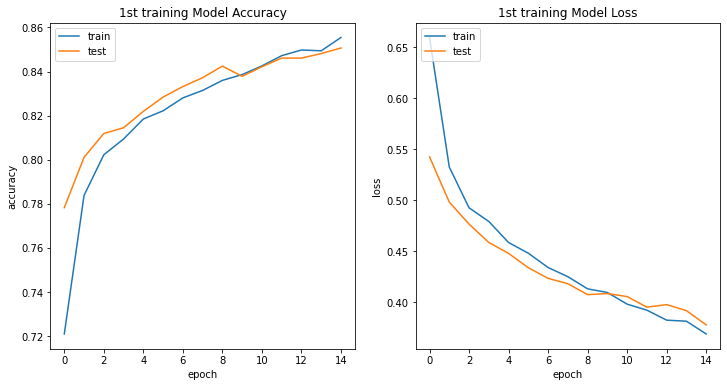

In [16]:
##作图显示第二次训练中accuracy和lost的变化
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
plt.subplot(121)
#plotting the Accuracy of test and training sets
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('1st training Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
#plotting the loss of test and training sets
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('1st training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

analyse of 1st model
VAL kappa
0.6947718343910547
analyse 1st model
report of val data
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     16545
           1       0.84      0.86      0.85     16545

    accuracy                           0.85     33090
   macro avg       0.85      0.85      0.85     33090
weighted avg       0.85      0.85      0.85     33090



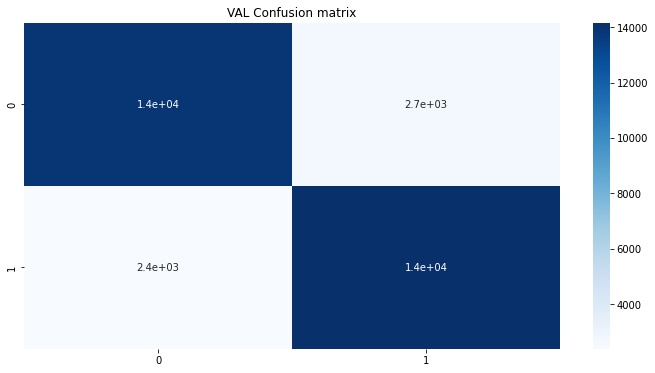

In [17]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
#---------------
from keras.models import load_model

model1 = load_model(MODEL_INIT, compile=False)
print("analyse of 1st model")


cf_matrix_val = confusion_matrix(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model1.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)

plt.figure(figsize = (12, 6))
sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
plt.title("VAL Confusion matrix")
# kappa VAL
kappa_val = cohen_kappa_score(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model1.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)
print("VAL kappa")
print(kappa_val)



print("analyse 1st model")
print("report of val data")
report = sklearn.metrics.classification_report(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model1.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)
print(report)

report of test data
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      7091
           1       0.84      0.86      0.85      7091

    accuracy                           0.85     14182
   macro avg       0.85      0.85      0.85     14182
weighted avg       0.85      0.85      0.85     14182

TEST kappa
0.697080806656325


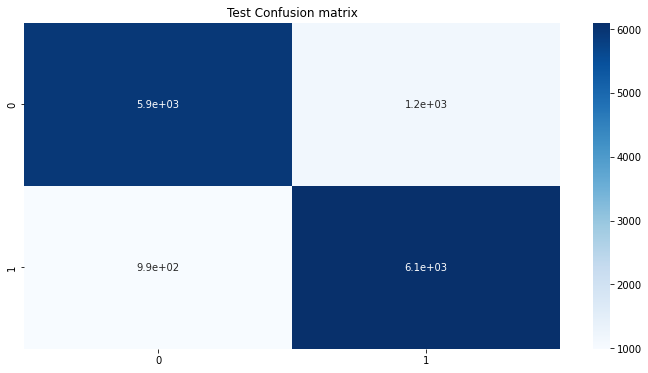

In [18]:
#------------------
cf_matrix_test = confusion_matrix(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model1.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)

plt.figure(figsize = (12, 6))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
plt.title("Test Confusion matrix")



print("report of test data")
import sklearn

report = sklearn.metrics.classification_report(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model1.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)
print(report)


# kappa TEST
kappa_test = cohen_kappa_score(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model1.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)
print("TEST kappa")
print(kappa_test)

In [19]:
model.evaluate_generator(val2_generator)

[0.397282238318575, 0.8473859171955274]

In [20]:
model.evaluate_generator(val_generator)

[0.3829039961978018, 0.8485404033365681]

In [21]:
model.evaluate_generator(train_generator)

[0.32795350197760065, 0.8705711695441093]

In [22]:
model.metrics_names

['loss', 'acc']

In [23]:
#model_checkpoint2 = ModelCheckpoint(filepath=MODEL_PATH,  monitor='val_accuracy')
model_checkpoint2 =ModelCheckpoint(filepath=MODEL_PATH, monitor='val_loss', mode='min')
#model_checkpoint2 =ModelCheckpoint(filepath=MODEL_PATH, monitor='val_acc', mode='max')
board_name2 = '/kaggle/working/stage2/' + now + '/'
board2 = TensorBoard(log_dir=board_name2,
                     histogram_freq=0,
                     write_graph=True,
                     write_images=True)
callback_list2 = [model_checkpoint2, board2, EarlyStopping(monitor='val_loss', patience=5)]


model.load_weights(MODEL_INIT)
for model1 in model.layers:
    model1.trainable = True
    
model.compile(optimizer=optimizers.Adam(lr=0.00001, clipnorm=1), loss = [focal_loss(gamma=2)], metrics=['accuracy'])

history2=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples / float(batch_size), epochs=epochs, 
validation_steps=nb_val_samples / float(batch_size), validation_data=val_generator, callbacks=callback_list2, verbose=1)

Epoch 1/15
1724/1723 [==============================] - 988s 573ms/step - loss: 0.1418 - acc: 0.8180 - val_loss: 0.0208 - val_acc: 0.7837
Epoch 2/15
1724/1723 [==============================] - 978s 567ms/step - loss: 0.0149 - acc: 0.7915 - val_loss: 0.0097 - val_acc: 0.7891
Epoch 3/15
1724/1723 [==============================] - 977s 567ms/step - loss: 0.0060 - acc: 0.8157 - val_loss: 0.0033 - val_acc: 0.8060
Epoch 4/15
1724/1723 [==============================] - 981s 569ms/step - loss: 0.0017 - acc: 0.8368 - val_loss: 7.4809e-04 - val_acc: 0.8447
Epoch 5/15
1724/1723 [==============================] - 976s 566ms/step - loss: 3.6800e-04 - acc: 0.8420 - val_loss: 1.5493e-04 - val_acc: 0.8454
Epoch 6/15
1724/1723 [==============================] - 979s 568ms/step - loss: 1.0228e-04 - acc: 0.8390 - val_loss: 6.8439e-05 - val_acc: 0.8407
Epoch 7/15
1724/1723 [==============================] - 974s 565ms/step - loss: 5.5546e-05 - acc: 0.8341 - val_loss: 4.1518e-05 - val_acc: 0.8369
Epoch 

In [24]:
model.evaluate_generator(train_generator)

[1.6540413324388483e-05, 0.7553218495078445]

In [25]:
model.evaluate_generator(val2_generator)

[1.6541140051861438e-05, 0.7512541553339378]

In [26]:
model.evaluate_generator(val_generator, verbose=1)

444/444 [==============================] - 62s 140ms/step


[1.6551295034538583e-05, 0.7573684952757016]

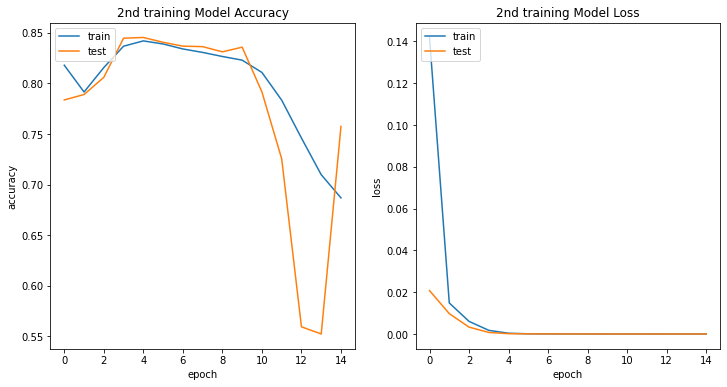

In [27]:
##作图显示第二次训练中accuracy和lost的变化
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
plt.subplot(121)
#plotting the Accuracy of test and training sets
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('2nd training Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
#plotting the loss of test and training sets
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('2nd training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

analyse of final model
VAL kappa
0.5025083106678755
analyse 1st model
report of val data
              precision    recall  f1-score   support

           0       0.68      0.95      0.79     16545
           1       0.92      0.55      0.69     16545

    accuracy                           0.75     33090
   macro avg       0.80      0.75      0.74     33090
weighted avg       0.80      0.75      0.74     33090



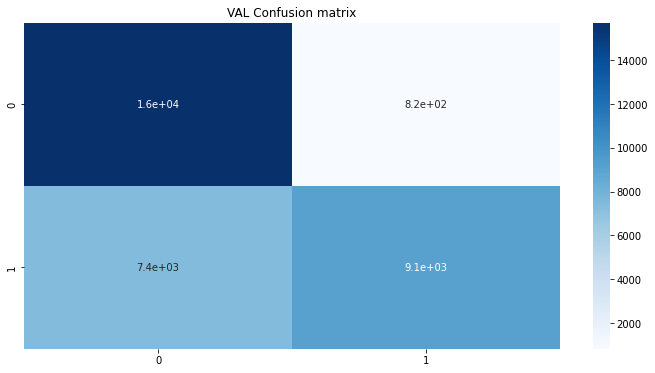

In [28]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
# model是最新版本的mode（stage 2）
# 混淆矩阵
from keras.models import load_model

model2 = load_model(MODEL_PATH, compile=False)
print("analyse of final model")


cf_matrix_val = confusion_matrix(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model2.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)

plt.figure(figsize = (12, 6))
sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
plt.title("VAL Confusion matrix")
# kappa VAL
kappa_val = cohen_kappa_score(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model2.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)
print("VAL kappa")
print(kappa_val)



print("analyse 1st model")
print("report of val data")
report = sklearn.metrics.classification_report(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model2.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)
print(report)

report of test data
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      7091
           1       0.92      0.56      0.70      7091

    accuracy                           0.76     14182
   macro avg       0.80      0.76      0.75     14182
weighted avg       0.80      0.76      0.75     14182

TEST kappa
0.5147369905514032


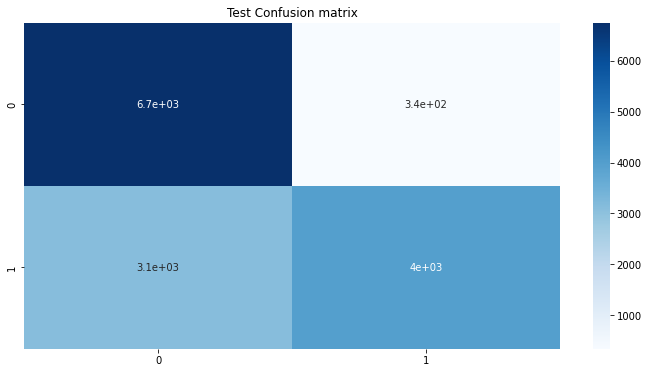

In [29]:
cf_matrix_test = confusion_matrix(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model2.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)

plt.figure(figsize = (12, 6))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
plt.title("Test Confusion matrix")



print("report of test data")
import sklearn

report = sklearn.metrics.classification_report(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model2.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)
print(report)


# kappa TEST
kappa_test = cohen_kappa_score(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model2.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)
print("TEST kappa")
print(kappa_test)